In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

In [2]:
def plot_causal_graph(adj_matrix, factor_list, results_serial):
    """
    Plot the CPDAG using pairwise correlations taken from results_serial
    *only* for entries with no conditioning set (sub_z == []).
    
    - Edge color encodes sign of the stored correlation.
    - Edge width scales with |corr|.
    - Arrow for one-way edges; line-style for symmetric (undirected) edges.
    - If a needed (i,j) pair has no no-sub_z entry, it is drawn in gray with 'n/a'.
    """
    #'#8e7dbe'
    #'#F2C14E'
    nodes = factor_list

    # Build a lookup: undirected key -> correlation
    # Use frozenset({i,j}) so (i,j) and (j,i) map to the same value
    corr_map = {}
    for i, j, sub_z, corr, p_value in results_serial:
        if not sub_z:  # no conditioning variables
            key = frozenset((i, j))
            # Keep the first encountered value; or overwrite if you prefer last-seen
            if key not in corr_map:
                corr_map[key] = corr

    G = nx.DiGraph()
    edge_info = []
    edge_labels = {}

    # Add edges from adjacency matrix and attach style from corr_map
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if adj_matrix[i, j] != 0:
                node_i = nodes[i]
                node_j = nodes[j]
                key = frozenset((i, j))
                pcorr = corr_map.get(key, np.nan)

                if np.isnan(pcorr):
                    edge_color = 'gray'  # fallback when no no-sub_z corr available
                    edge_width = 1.5
                    label = 'n/a'
                    weight = 0.0
                else:
                    edge_color = "#d62728"if pcorr > 0 else "#1f77b4"
                    edge_width = 10 * abs(pcorr)
                    label = f"{pcorr:+.2f}"
                    weight = pcorr

                G.add_edge(node_i, node_j, weight=weight)
                edge_info.append((node_i, node_j, edge_color, edge_width))
                edge_labels[(node_i, node_j)] = label

    # Layout & node draw
    pos = nx.circular_layout(G)
    # label_pos = {n: (p[0] * 1.2, p[1] * 1.2) for n, p in pos.items()}

    plt.figure(figsize=(11, 11), dpi=900)
    labels = {n: f"${n}$" for n in G.nodes()} 
    nx.draw_networkx_nodes(
        G, pos,
        node_color=['white'],
        edgecolors='black',
        node_size=1500
    )
    nx.draw_networkx_labels(
    G, pos,
    labels=labels,
    font_size=15,
    font_family="Arial",
    font_color="black"
    )

    # Draw edges (merge symmetric pairs into undirected style)

    angles = {n: np.arctan2(pos[n][1], pos[n][0]) for n in G.nodes()}

    handled = set()
    for u, v, color, width in edge_info:
        if (v, u) in handled:
            continue

        duv = angles[v] - angles[u]
        if duv > np.pi:
            duv -= 2*np.pi
        elif duv < -np.pi:
            duv += 2*np.pi

        sign = 1 if duv > 0 else -1
        arc_rad = 0.2 * sign

        if G.has_edge(v, u):
            # symmetric → draw as undirected line
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u, v)], width=width, edge_color=color,
                arrows=False, connectionstyle=f'arc3,rad={arc_rad}',
                min_source_margin=20, min_target_margin=20
            )
            handled.add((u, v))
        else:
            # one-way → directed arrow
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u, v)], width=width, edge_color=color,
                arrows=True, arrowstyle="simple", arrowsize=20, connectionstyle=f'arc3,rad={arc_rad}',
                min_source_margin=20, min_target_margin=20
            )
            handled.add((u, v))

    # Edge labels
    # nx.draw_networkx_edge_labels(
    #     G, pos,
    #     edge_labels=edge_labels,
    #     font_size=14,
    #     font_color='black',
    #     font_family="arial",
    #     rotate=True,
    #     label_pos=0.5,
    #     bbox=dict(facecolor='none', edgecolor='none', pad=0)
    # )

    # Legend
    pos_patch = mpatches.Patch(color="#d62728", label='Positive')
    neg_patch = mpatches.Patch(color="#1f77b4", label='Negative')
    plt.legend(handles=[pos_patch, neg_patch], loc='lower left', fontsize=15, frameon=False)

    plt.gca().margins(x=0.3, y=0.3)
    plt.axis("equal")
    plt.box(False)
    plt.show()

In [3]:
from pc_gcastle import PC
from random import shuffle

def run_pc_analysis(df, factor_list, alpha=0.05, shuffle_factors=False, ci_test='spearman'):
    """
    Run PC algorithm for a selected subset of factors.
    
    Parameters:
        df (pd.DataFrame): Original dataframe containing 'factor', 'cbsacode', and 'SSAMI'.
        factor_list (list): List of factor names to include in the analysis.
        alpha (float): Significance level for conditional independence tests.
        shuffle_factors (bool): Whether to shuffle the factor list randomly.
    
    Returns:
        pc (PC object): The trained PC model.
    """
    
    if shuffle_factors:
        shuffle(factor_list)
        print(factor_list)
    
    # Filter and pivot
    df_select = df.loc[df['factor'].isin(factor_list)]


    dfp = df_select.pivot(index=["cbsacode"], columns="factor", values='FsAMI').reset_index()
    # Reorder columns explicitly to match shuffled factor_list
    dfp = dfp[['cbsacode'] + factor_list]
    # Drop missing values and isolate data matrix
    df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()
    print(df_cleaned.shape)
    data_matrix = df_cleaned.to_numpy()

    # Run PC algorithm
    pc = PC(alpha=alpha, ci_test = ci_test)
    pc.learn(data_matrix, columns=factor_list)
    
    print("Learned skeleton (CPDAG):")
    plot_causal_graph(pc.causal_matrix, factor_list, pc._results)
    
    return pc._results

In [4]:
from collections import defaultdict
import numpy as np
import pandas as pd
from itertools import permutations
import math

def run_pc_all_order(df, factor_list, alpha=0.05, ci_test='spearman',
                     stability_threshold=0.5, verbose=True):
    """
    Run PC multiple times with shuffled factor orders and return stable directed edges.
    
    Returns:
        stable_adj (np.ndarray): binary adjacency matrix of stable directed edges (i → j)
        edge_freq_df (pd.DataFrame): DataFrame of all edge frequencies (from, to, freq)
        final_pc._results (list): Last PC _results for plotting
    """
    # Step 1: Store edge frequencies as (from_name, to_name) → count
    edge_count_dict = defaultdict(int)

    # p = len(factor_list)
    # if p > 8:  # adjust limit as needed
    #     raise ValueError(f"Too many variables ({p}), {p}! permutations is not feasible.")

    for run, shuffled in enumerate(permutations(factor_list), start=1):
        shuffled = list(shuffled)

        # Step 3: Pivot and reorder columns to match shuffled
        df_sub = df[df['factor'].isin(shuffled)]
        dfp = df_sub.pivot(index="cbsacode", columns="factor", values="FsAMI").reset_index()
        dfp = dfp[['cbsacode'] + shuffled]
        df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()
        data_matrix = df_cleaned.to_numpy()

        # Step 4: Run PC
        pc = PC(alpha=alpha, ci_test=ci_test)
        pc.learn(data_matrix, columns=shuffled)

        var_names = pc.causal_matrix.index.tolist()

        # Step 5: Record directed edges (i → j) using actual var names
        cm = np.array(pc.causal_matrix)
        var_names = pc.causal_matrix.columns  # Tensor

        for i, from_var in enumerate(var_names):
            for j, to_var in enumerate(var_names):
                if cm[i, j] == 1:
                    edge_count_dict[(from_var, to_var)] += 1

        if verbose:
            print(f"Run {run+1}/{math.factorial(p)} complete.")

    # Step 6: Compute frequency for all possible directed edges
    all_edges = [(a, b) for a in factor_list for b in factor_list if a != b]
    edge_freq_df = pd.DataFrame([
        {"from": a, "to": b, "count": edge_count_dict[(a, b)],"freq": edge_count_dict[(a, b)] / math.factorial(p)}
        for (a, b) in all_edges
    ])

    # Step 7: Build adjacency matrix with same order as factor_list
    var_idx = {v: i for i, v in enumerate(factor_list)}
    stable_adj = np.zeros((len(factor_list), len(factor_list)), dtype=int)

    for _, row in edge_freq_df.iterrows():
        if row["freq"] >= stability_threshold:
            i = var_idx[row["from"]]
            j = var_idx[row["to"]]
            stable_adj[i, j] = 1

    # Step 8: Plot and return
    df_sub = df[df['factor'].isin(factor_list)]
    dfp = df_sub.pivot(index="cbsacode", columns="factor", values="FsAMI").reset_index()
    dfp = dfp[['cbsacode'] + factor_list]
    df_cleaned = dfp.drop(columns=["cbsacode"]).dropna()
    data_matrix = df_cleaned.to_numpy()
    print(data_matrix.shape)
    pc = PC(alpha=alpha, ci_test=ci_test)
    pc.learn(data_matrix, columns=factor_list)

    print(factor_list)
    print(pc._results)
    print("Stable CPDAG from shuffled PC runs:")
    plot_causal_graph(stable_adj, factor_list, pc._results)

    return stable_adj, edge_freq_df, pc._results

In [5]:
# df = pd.read_csv('../00_data/04_output/FsAMIs_pop_allk_aic.csv')
df1 = pd.read_csv('../00_data/04_output/FsAMIs_pop_allk_allmatrc.csv')
df2 = pd.read_csv('../00_data/04_output/FsAMIs_pop_allk_allmatrc_add_feature.csv')

df = pd.concat([df1, df2], ignore_index=True)

df.loc[df['factor'] == 'gdp', 'factor'] = 'GDP'
df.loc[df['factor'] == 'mental_health_providers', 'factor'] = 'MHP'
df.loc[df['factor'] == 'DEPRESSION', 'factor'] = 'DEP'
df.loc[df['factor'] == 'noise50n', 'factor'] = 'NOI'
df.loc[df['factor'] == 'BINGE', 'factor'] = 'ED'
df.loc[df['factor'] == 'FFR20', 'factor'] = 'FFR'
df.loc[df['factor'] == 'LPA', 'factor'] = 'PI'



In [6]:

# --- 1) Collapse to one row per (factor, k) with final-model metrics -----------
def summarize_k_metrics(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    df_long: output of calculate_FsAMIs (many rows per (factor,k), one per CBSA)
    Returns a per-(factor,k) table with metrics (taking the first occurrence).
    """
    # Columns that are constant per (factor,k) coming from your code
    keep_cols = [
        "factor","k",
        "AIC","BIC","AICc",
        "CV_RMSE_final",
        "LASSO_R2_unused","LASSO_n_eigs_unused",
        "final_moran_p","final_moran_value",
        "baseline_moran_p","baseline_moran_value",
        "selected_m_eigs","beta","p_value","CI_lower","CI_upper"
    ]
    cols_present = [c for c in keep_cols if c in df_long.columns]
    # Take first (they're repeated identically for each CBSA)
    g = (df_long
         .drop_duplicates(subset=["factor","k"] + [c for c in cols_present if c not in ["factor","k"]])
         .loc[:, cols_present])
    return g.reset_index(drop=True)

# --- 2) Selection rules --------------------------------------------------------
def choose_k_per_factor(
    k_table: pd.DataFrame,
    rule: str = "aicc",          # "aic" | "bic" | "aicc" | "cv_rmse" | "combo"
    alpha: float = 0.05,
    prefer_smaller_k: bool = True
) -> pd.DataFrame:
    """
    Pick one k per factor using the chosen rule.
    Applies a hard feasibility filter first: final_moran_p >= alpha.
    If no k is feasible for a factor, falls back to the row with the LARGEST final_moran_p,
    then uses the rule within that fallback set (usually 1 row, but tie-safe).
    """
    # Split feasible vs fallback by factor
    out_rows = []
    for fac, g in k_table.groupby("factor"):
        feasible = g.loc[g["final_moran_p"] >= alpha].copy()
        if feasible.empty:
            # fallback: pick the rows with the best (largest) Moran p, then apply rule
            max_p = g["final_moran_p"].max()
            feasible = g.loc[g["final_moran_p"] == max_p].copy()

        # ranking keys by rule
        if rule.lower() == "aic":
            feasible["_key"] = list(zip(feasible["AIC"], feasible["k"] if prefer_smaller_k else np.zeros(len(feasible))))
        elif rule.lower() == "bic":
            feasible["_key"] = list(zip(feasible["BIC"], feasible["k"] if prefer_smaller_k else np.zeros(len(feasible))))
        elif rule.lower() == "aicc":
            feasible["_key"] = list(zip(feasible["AICc"], feasible["k"] if prefer_smaller_k else np.zeros(len(feasible))))
        elif rule.lower() == "cv_rmse":
            feasible["_key"] = list(zip(feasible["CV_RMSE_final"], feasible["k"] if prefer_smaller_k else np.zeros(len(feasible))))
        elif rule.lower() == "lasso":
            r2 = feasible["LASSO_R2_unused"].fillna(0.0)
            feasible["_key"] = list(zip(r2, feasible["k"] if prefer_smaller_k else np.zeros(len(feasible))))
        elif rule.lower() == "combo":
            # Combined: prioritize predictive fit, then little leftover structure, then parsimony
            # (CV_RMSE_final ↑ bad; LASSO_R2_unused ↑ bad; BIC ↑ bad; k ↑ bad)
            # Use None-safe fills
            r2 = feasible["LASSO_R2_unused"].fillna(0.0)
            bic = feasible["BIC"].fillna(np.inf)
            feasible["_key"] = list(zip(
                feasible["CV_RMSE_final"],
                r2,
                bic,
                feasible["k"] if prefer_smaller_k else np.zeros(len(feasible))
            ))
        else:
            raise ValueError(f"Unknown rule: {rule}")

        pick = feasible.sort_values("_key", ascending=True).iloc[0].drop(labels=["_key"])
        out_rows.append(pick)

    best_k = pd.DataFrame(out_rows).reset_index(drop=True)
    best_k.rename(columns={"k":"k_selected"}, inplace=True)
    best_k["rule"] = rule
    best_k["alpha_filter"] = alpha
    return best_k

# --- 3) Pull the chosen FsAMI rows for your downstream analysis/plots ----------
def slice_fsami_by_best_k(df_long: pd.DataFrame, best_k: pd.DataFrame) -> pd.DataFrame:
    """
    Join back to the long table to keep only rows (factor, k_selected) per CBSA.
    """
    return (df_long
            .merge(best_k[["factor","k_selected"]], on="factor", how="inner")
            .query("k == k_selected")
            .drop(columns=["k_selected"])
            .reset_index(drop=True))

In [7]:
k_table = summarize_k_metrics(df)

best_k_aic = choose_k_per_factor(k_table, rule="aic", alpha=0.05)
best_k_bic = choose_k_per_factor(k_table, rule="bic", alpha=0.05)
best_k_aicc = choose_k_per_factor(k_table, rule="aicc", alpha=0.05)
best_k_cv = choose_k_per_factor(k_table, rule="cv_rmse", alpha=0.05)
best_k_lasso = choose_k_per_factor(k_table, rule="lasso", alpha=0.05)
# combined rule: CV-RMSE → LASSO_R2_unused → BIC → smaller k
best_k_combo = choose_k_per_factor(k_table, rule="combo", alpha=0.05)

# 3) Keep only the chosen (factor, k) FsAMI residuals
df_fsami_best = slice_fsami_by_best_k(df, best_k_cv)

In [8]:
df_check = df_fsami_best.drop(columns=['cbsacode','FsAMI']).drop_duplicates()
df_check

,factor,k,baseline_moran_value,baseline_moran_p,final_moran_value,final_moran_p,selected_m_eigs,beta,p_value,CI_lower,CI_upper,AIC,BIC,AICc,CV_RMSE_final,LASSO_R2_unused,LASSO_n_eigs_unused
0,ED,11,0.653093,0.001,0.026501,0.063,44,1.022914,0.000000e+00,1.018191,1.027637,-1842.055484,-1622.441186,-1836.833262,0.084525,0.000000e+00,0
875,CSMOKING,9,0.502271,0.001,0.027586,0.084,32,0.950327,0.000000e+00,0.942783,0.957871,-1019.318111,-856.994499,-1016.484778,0.136194,0.000000e+00,0
1750,DEP,9,0.701234,0.001,0.029164,0.055,66,0.993780,0.000000e+00,0.989925,0.997635,-2188.492209,-1863.844985,-2176.849529,0.069514,3.621915e-01,142
2625,DIABETES,9,0.629113,0.001,0.028835,0.056,28,0.961094,0.000000e+00,0.954771,0.967418,-1254.200193,-1110.973476,-1251.996401,0.118331,0.000000e+00,0
3500,PI,13,0.564892,0.001,0.023276,0.067,28,0.955157,0.000000e+00,0.948471,0.961842,-1166.784283,-1023.557567,-1164.580492,0.125334,1.454380e-01,51
4375,OBESITY,12,0.482200,0.001,0.023561,0.076,23,0.978199,0.000000e+00,0.973044,0.983354,-1675.305028,-1555.949430,-1673.773814,0.092718,0.000000e+00,0
5250,adult_smoking,12,0.395357,0.001,0.022726,0.086,25,0.383379,1.572342e-152,0.360384,0.406374,915.970458,1044.874503,917.755582,0.416307,7.036696e-02,32
6125,adult_obesity,12,0.355120,0.001,0.019722,0.109,24,0.405941,1.647794e-173,0.383854,0.428028,851.291954,975.421775,852.947614,0.393278,3.618239e-03,1
7000,excessive_drinking,13,0.284889,0.001,0.018532,0.104,24,0.426216,3.364532e-183,0.403995,0.448437,873.130912,997.260733,874.786572,0.399787,0.000000e+00,0
7875,diabetes_prevalence,12,0.392757,0.001,0.022593,0.081,28,0.406516,5.320678e-171,0.384175,0.428857,878.289608,1021.516324,880.493399,0.398166,0.000000e+00,0


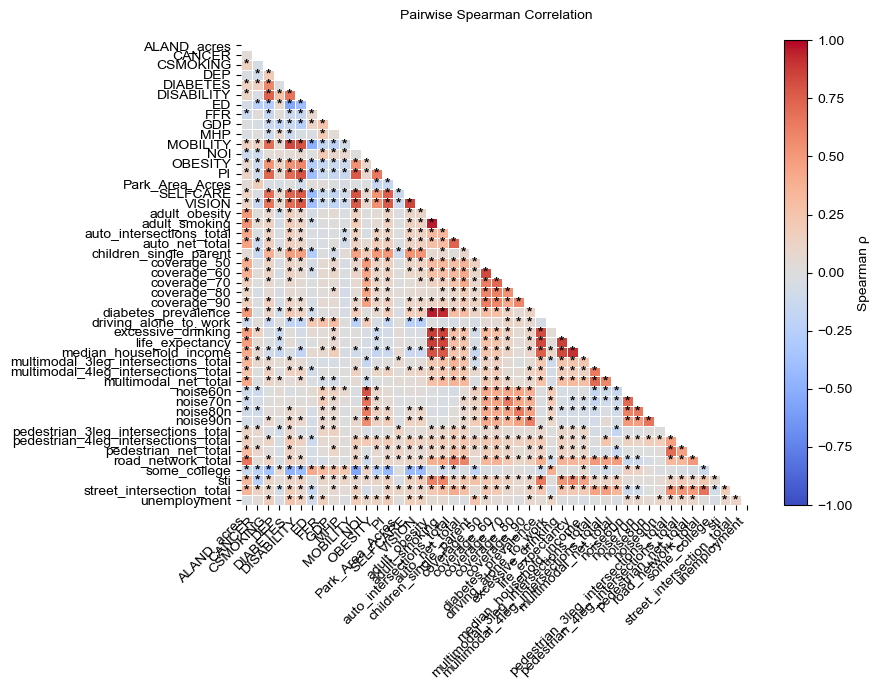

In [9]:
import sys, os
sys.path.append(os.path.abspath(".."))  # or path to your project root
from function import spearman_corr_heatmap


sami_wide = df_fsami_best.pivot(index="cbsacode", columns="factor", values="FsAMI")

cols = [c for c in sami_wide.columns if c not in ['cbsacode']]
corr, pvals = spearman_corr_heatmap(sami_wide, columns=cols,figsize=(9, 7), savepath=None)

In [10]:
df['factor'].unique()

array(['ED', 'CSMOKING', 'DEP', 'DIABETES', 'PI', 'OBESITY',
       'adult_smoking', 'adult_obesity', 'excessive_drinking',
       'diabetes_prevalence', 'some_college', 'unemployment',
       'children_single_parent', 'MHP', 'median_household_income',
       'driving_alone_to_work', 'sti', 'FFR', 'GDP', 'coverage_50',
       'coverage_60', 'coverage_70', 'coverage_80', 'coverage_90', 'NOI',
       'noise60n', 'noise70n', 'noise80n', 'noise90n', 'CANCER', 'VISION',
       'MOBILITY', 'SELFCARE', 'DISABILITY', 'Park_Area_Acres',
       'ALAND_acres', 'life_expectancy', 'road_network_total',
       'auto_net_total', 'multimodal_net_total', 'pedestrian_net_total',
       'street_intersection_total', 'auto_intersections_total',
       'multimodal_3leg_intersections_total',
       'multimodal_4leg_intersections_total',
       'pedestrian_3leg_intersections_total',
       'pedestrian_4leg_intersections_total'], dtype=object)

## PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# pca_factors = ['DIABETES', 'OBESITY', 'BINGE', 'CSMOKING', 'LPA']
pca_factors = ['DIABETES', 'OBESITY', 'BINGE', 'CSMOKING']
cols_to_use = ['cbsacode'] + pca_factors
filtered_df = df[df['factor'].isin(pca_factors)]
pca_wide = filtered_df.pivot_table(index='cbsacode', columns='factor', values='FsAMI')


# Standardize FsAMI values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_wide[pca_factors])

# Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Append to original df
pc1_scores = X_pca[:, 0]
cbsacodes = pca_wide.index

pca_result_df = pd.DataFrame({
    'cbsacode': cbsacodes,
    'factor': 'PCA',              # tag new synthetic variable
    'FsAMI': pc1_scores           # PC1 values as SAMI-like scores
})

for col in ['best_k', 'baseline_moran_value', 'baseline_moran_p',
            'final_moran_value', 'final_moran_p', 'selected_m_eigs',
            'beta', 'p_value', 'CI_lower', 'CI_upper', 'AIC']:
    pca_result_df[col] = None

df_with_pca = pd.concat([df, pca_result_df], ignore_index=True)

In [11]:
my_factors = ["DEP", "MHP","ED",'DISABILITY',"GDP",'life_expectancy','pedestrian_3leg_intersections_total','NOI','children_single_parent']
# my_factors = ["DEP", "NOI", "MHP","GDP","ED","PI"]

## VIF

In [12]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

filtered_df = df_filter[df_filter['factor'].isin(my_factors)]
fsmis_wide = filtered_df.pivot_table(index='cbsacode', columns='factor', values='FsAMI')


fsmis_clean = fsmis_wide.dropna()
X = sm.add_constant(fsmis_clean)

vif_data = pd.DataFrame({
    "factor": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})


# Display VIF
print(vif_data)

NameError: name 'df_filter' is not defined

In [ ]:
pc_result = run_pc_analysis(df_fsami_best, my_factors, alpha=0.05, shuffle_factors=True, ci_test='spearman')

['pedestrian_3leg_intersections_total', 'children_single_parent', 'NOI', 'DEP', 'DISABILITY', 'MHP', 'ED', 'life_expectancy', 'GDP']
(826, 9)
Learned skeleton (CPDAG):


/var/folders/xn/k3tchqyx5bn081b3tlx0k4940000gn/T/ipykernel_59638/2307504936.py:93: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


In [ ]:
stable_adj, edge_freq_df, pc_results = run_pc_all_order(df_fsami_best, my_factors, alpha=0.05, ci_test='spearman',
                     stability_threshold=0.5, verbose=False)

---

In [ ]:
records = []
for (x_idx, y_idx,cond_indices,corr, p_val ) in pc_result:
    # Convert x_idx and y_idx to factor names:
    x_name = my_factors[x_idx]
    y_name = my_factors[y_idx]
    # Convert conditioning indices (if any) to factor names:
    cond_names = [my_factors[z] for z in cond_indices]

    records.append({
        "X": x_name,
        "Y": y_name,
        "Z":  cond_names,
        "Spearman":corr,
        "p value": p_val
    })

df = pd.DataFrame(records)


In [ ]:
df

,X,Y,Z,Spearman,p value
0,GDP,ED,[],0.137301,0.000046
1,GDP,DEP,[],-0.147803,0.000011
2,GDP,PI,[],-0.134870,0.000063
3,GDP,MHP,[],0.038635,0.253879
4,GDP,NOI,[],0.135964,0.000055
...,...,...,...,...,...
86,GDP,NOI,"[ED, DEP, PI]",0.162296,0.000001
87,DEP,MHP,"[GDP, ED, NOI]",0.078273,0.020654
88,DEP,NOI,"[GDP, ED, MHP]",0.090867,0.007187
89,PI,MHP,"[GDP, ED, NOI]",-0.115401,0.000630


In [ ]:
df.to_csv("../05_result/pc_result_0909.csv",index=False)

In [ ]:
import pandas as pd
import ast

# Load your CSV
df = pd.read_csv("../05_result/pc_result_0909.csv")


# Clean Z column
def clean_z(z):
    try:
        items = ast.literal_eval(z)
        if isinstance(items, list) and len(items) == 0:
            return '-'
        elif isinstance(items, list):
            return ', '.join(str(i) for i in items)
    except:
        return z
    return z

# Apply formatting
df['Z'] = df['Z'].apply(clean_z)
df['Spearman'] = df['Spearman'].astype(float).apply(lambda x: f"{x:.3f}")
df['p value'] = df['p value'].astype(float).apply(lambda x: r"\textless{} 0.001" if x < 0.001 else f"{x:.3f}")
# Apply italics formatting
for col in ["X", "Y", "Z"]:
    df[col] = df[col].apply(lambda v: f"\\textit{{{v}}}")

# Split side by side
half = len(df) // 2 + len(df) % 2
df1 = df.iloc[:half].reset_index(drop=True)
df2 = df.iloc[half:].reset_index(drop=True)
combined = pd.concat([df1, df2], axis=1)
combined.columns = ['X', 'Y', 'Z', 'Spearman', 'p value', 'X', 'Y', 'Z', 'Spearman', 'p value']

# Export to LaTeX
latex_code = combined.to_latex(
    index=False,
    column_format="lllrr|lllrr",
    escape=False
)

In [ ]:
with open("../05_result/pc_result_table.tex", "w") as f:
    f.write(latex_code)